In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.preprocessing import normalize
from scipy import interp
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import Pipeline
sys.path.append('/home/lolo/Desktop/dnnComm/vde/vde/')
from vde import VDE 


name= '/home/lolo/Desktop/dnnComm/RML2016.10a_dict.pkl'
data = pd.read_pickle(name)

In [2]:
list = []
for d in data:
    list.append(d)    

In [3]:
# what is the best normalization strategy?
# time-lag is considered in features, data augmentation and cost funstion.
lag_time = 8
trajs = []
stride = 20
for l in range(len(list)):
    d = data[list[l]]
    for i in range(0, len(d), stride):
        dd = normalize(d[i, :, :], axis=1, norm='l2').T
        #dd = normalize(dd[i, : :], axis=0, norm='l2')
        #dd = d[i, :, :].T
        Dt = dd.shape
        dddd = dd
        for t in range(1, lag_time):
            ddd = np.zeros(Dt)
            ddd[:-t] = dd[:-t] - dd[t:] # lag-differences as features
            dddd = np.append(dddd, ddd, axis=1)
        trajs.append(dddd)
print ('samples,features', trajs[0].shape)    
print ('#data', len(trajs))

samples,features (128, 16)
#data 11000


In [5]:
mdl = VDE(trajs[0].shape[-1], lag_time=lag_time,
          hidden_size=256, hidden_layer_depth=3,
          batch_size=100, n_epochs=1, cuda=False, 
          sliding_window=False, dropout_rate=0.3,
          learning_rate=1E-3, autocorr=True)

In [7]:
# for some reasons autocorr_loss does behave properly!
mdl.fit(trajs)

Epoch: 0
Batch 100, loss = 0.8578
rec_loss = 0.0375, autocorr_loss = 0.8203
Batch 200, loss = 0.9806
rec_loss = 0.0277, autocorr_loss = 0.9529
Batch 300, loss = 0.8215
rec_loss = 0.0350, autocorr_loss = 0.7865
Batch 400, loss = 0.8390
rec_loss = 0.0407, autocorr_loss = 0.7983
Batch 500, loss = 0.8945
rec_loss = 0.0324, autocorr_loss = 0.8620
Batch 600, loss = 0.7518
rec_loss = 0.0312, autocorr_loss = 0.7207
Batch 700, loss = 0.8695
rec_loss = 0.0271, autocorr_loss = 0.8424
Batch 800, loss = 0.6111
rec_loss = 0.0287, autocorr_loss = 0.5824
Batch 900, loss = 0.7951
rec_loss = 0.0214, autocorr_loss = 0.7737
Batch 1000, loss = 0.7815
rec_loss = 0.0182, autocorr_loss = 0.7633
Batch 1100, loss = 0.8436
rec_loss = 0.0253, autocorr_loss = 0.8183
Batch 1200, loss = 0.8226
rec_loss = 0.0203, autocorr_loss = 0.8023
Batch 1300, loss = 0.7054
rec_loss = 0.0207, autocorr_loss = 0.6847
Batch 1400, loss = 0.8583
rec_loss = 0.0180, autocorr_loss = 0.8403
Batch 1500, loss = 0.8166
rec_loss = 0.0172, aut

In [8]:
delta = np.int(data[list[0]].shape[0]/stride)

def scatter(decomposition, cmap='plasma', stride=1, l=0, ax=None):

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(4, 4))
    cmap = plt.get_cmap(cmap)
    w = np.concatenate(decomposition.transform(trajs[l*delta:(l+1)*delta]))[::stride].ravel()
    w -= w.min()
    w /= w.max()
    ax.scatter(*np.vstack(trajs[l*delta:(l+1)*delta])[::stride, 0:2].T, c=cmap(w), s=2)

    return ax

def hist(decomposition, cmap='plasma', stride=1, l=0, ax=None):

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(4, 4))
    cmap = plt.get_cmap(cmap)
    w = np.concatenate(decomposition.transform(trajs[l*delta:(l+1)*delta]))[::stride].ravel()
    ax.hist(w, bins=100)

    return ax
def clean_up(ax):
    ax.axis('off')
    ax.grid('off')
    ax.set_xticks([])
    ax.set_yticks([])

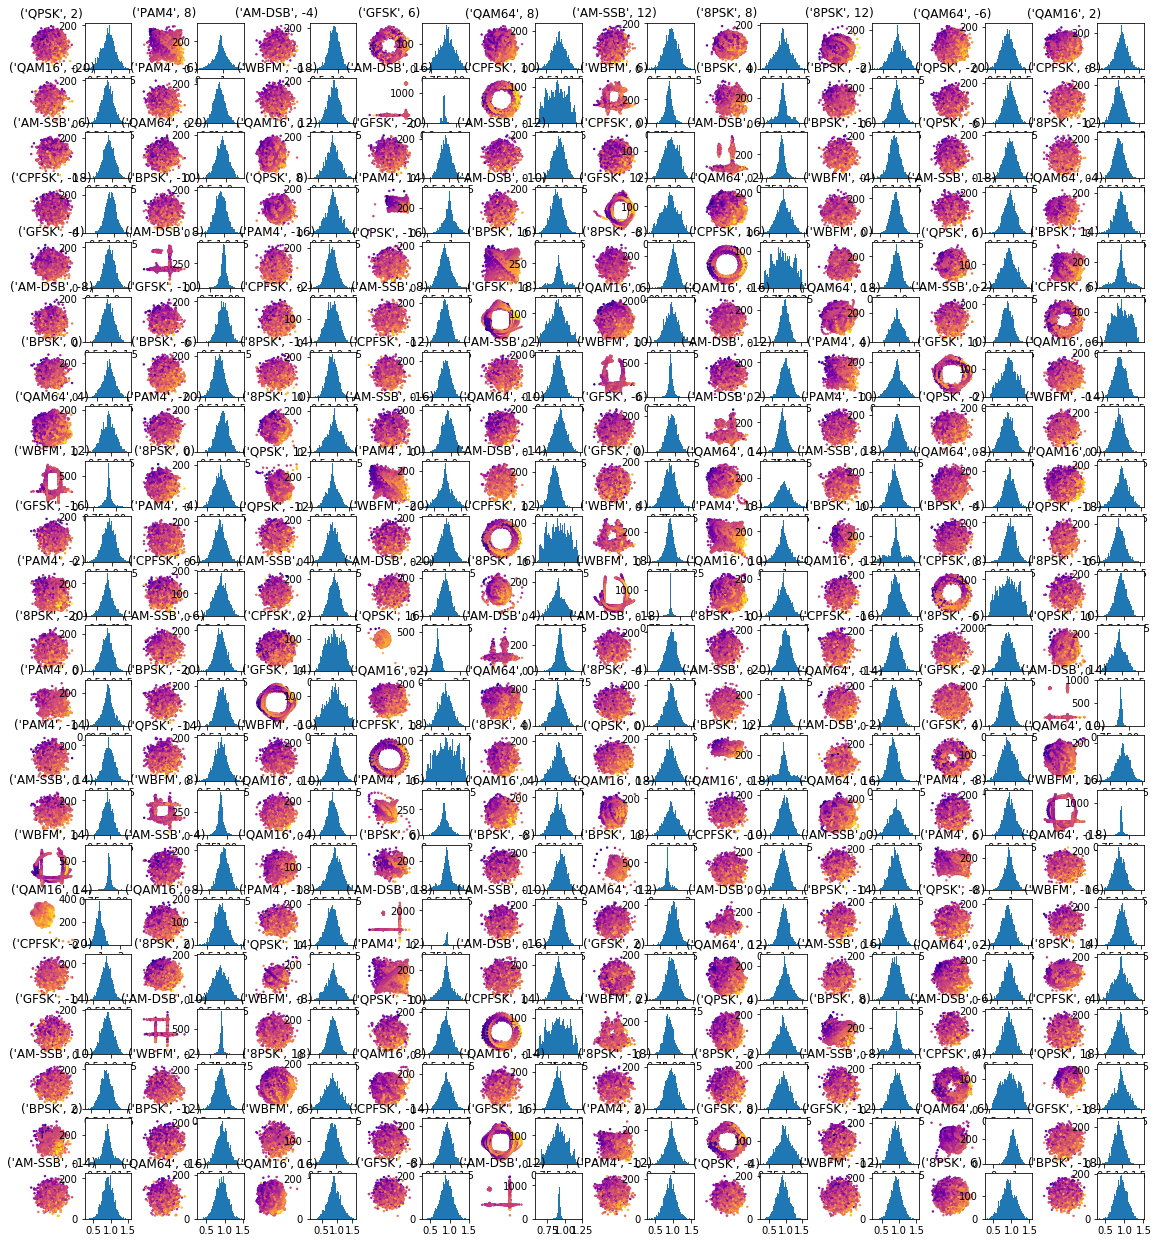

In [10]:
fig = plt.figure(figsize=(2*10, 1*22))
c = 0
for i in range(22):
    for j in range(10):
        ax1 = fig.add_subplot(1*22, 2*10, i*2*10+2*j+1)
        ax2 = fig.add_subplot(1*22, 2*10, i*2*10+2*j+2)
        scatter(mdl, cmap='plasma_r', l=c, ax=ax1)
        ax1.set_title(list[c]); clean_up(ax1)
        hist(mdl, cmap='plasma_r', l=c, ax=ax2)
        #ax2.set_title('Signature')
        c += 1
#plt.savefig('result.png')
#plt.close(fig)

In [73]:
import zmq
import array

socket_str = 'tcp://127.0.0.1:5557'


def zmq_consumer(T):
    context = zmq.Context()
    results_receiver = context.socket(zmq.PULL)
    results_receiver.connect(socket_str)
    raw_data = results_receiver.recv()
    float_list = array.array('f', raw_data)
    t = 0
    data = []
    for signal_val in float_list:
        data.append(np.float(signal_val))
        t += 1
        if t >= T: 
            break;
    DATA = np.zeros((T), dtype=np.float)
    DATA[0:len(data)] = data
    return DATA                              

Text(0.5,1,'SDR data')

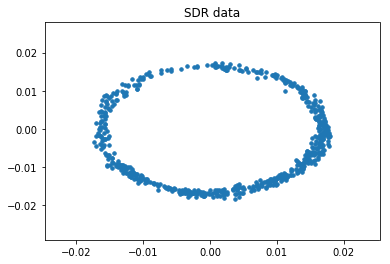

In [74]:
L = 5
T = 128*2*L
data_ = zmq_consumer(T)
plt.figure()
plt.scatter(data_[0:T:2], data_[1:T:2], s=12)
plt.title('SDR data')

In [78]:
lag_time = 8
trajs_test = []

for i in range(np.int(T/(128*2))):
    dd = np.zeros((128, 2))
    dd[:, 0] = data_[i*2*128:(i+1)*2*128:2]
    dd[:, 1] = data_[i*2*128+1:(i+1)*2*128:2]
    dd = normalize(dd, axis=1, norm='l2')
    Dt = dd.shape
    dddd = dd
    for t in range(1, lag_time):
        ddd = np.zeros(Dt)
        ddd[:-t] = dd[:-t] - dd[t:]
        dddd = np.append(dddd, ddd, axis=1)
    trajs_test.append(dddd)
print (len(trajs_test), trajs_test[0].shape)    

5 (128, 16)


In [79]:
def scatter(decomposition, cmap='plasma', stride=1, ax=None):

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(4, 4))
    cmap = plt.get_cmap(cmap)
    w = np.concatenate(decomposition.transform(trajs_test[:]))[::stride].ravel()
    w -= w.min()
    w /= w.max()
    ax.scatter(*np.vstack(trajs_test[:])[::stride, 0:2].T, c=cmap(w),s=12 )

    return ax

def hist(decomposition, cmap='plasma', stride=1, l=0, ax=None):

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(4, 4))
    cmap = plt.get_cmap(cmap)
    w = np.concatenate(decomposition.transform(trajs_test[:]))[::stride].ravel()
    ax.hist(w, bins=100)

    return ax
def clean_up(ax):
    ax.axis('off')
    ax.grid('off')
    ax.set_xticks([])
    ax.set_yticks([])

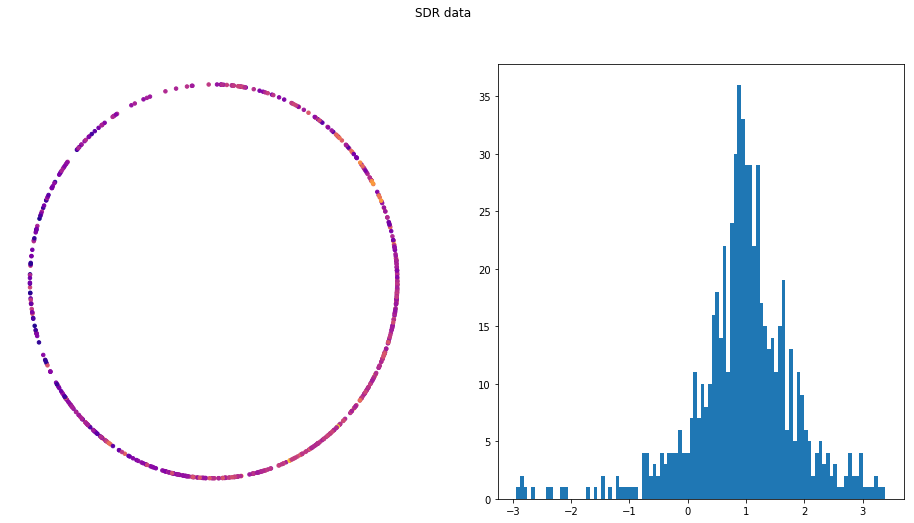

In [84]:
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
scatter(mdl, cmap='plasma_r', ax=ax1)
clean_up(ax1)
hist(mdl, cmap='plasma_r', ax=ax2)
fig.suptitle('SDR data')
plt.savefig('result.png')